In [1]:
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from segment_anything import sam_model_registry, SamPredictor

import cv2, os
from time import perf_counter
import torch
import numpy as np
from imantics import Mask, Polygons
import matplotlib.pyplot as plt

In [2]:
# from plot_bbox import draw_bbox, show_mask, show_box

def draw_bbox(source_img, boxes, labels, fname, prob):
    draw = ImageDraw.Draw(source_img)
    print(boxes)
    print(labels)
    print(prob)
    #font = ImageFont.truetype("arial.ttf", 50)
    font = ImageFont.load_default()
    k = 0
    for i in range(len(boxes)):
        draw.rectangle(((boxes[i][0], boxes[i][1]), (boxes[i][0]+boxes[i][2], boxes[i][1]+boxes[i][3])), outline="white", width = 10)
        draw.text((boxes[i][0], boxes[i][1]), labels[k]+": " +str(prob[k]), font = font, fill = "white", align = "center", stroke_width = 1) 
        k += 1
    source_img.save("pred_{}".format(fname))
    
def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    ax.text(x0, y0+7, label, fontsize = 10, color ="white")

In [17]:
sam = sam_model_registry["vit_h"](checkpoint = "./models/sam_vit_h_4b8939.pth")
sam.to(device = "cpu")
sam_predictor = SamPredictor(sam)

In [18]:
from segment_anything import SamAutomaticMaskGenerator
mask_generator = SamAutomaticMaskGenerator(sam)

In [19]:
image_bgr = cv2.imread('images/coating_loss/DSC_5641.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

In [20]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(result)
annotated_image = mask_annotator.annotate(image_bgr, detections)

plt.imshow(annotated_image)

ModuleNotFoundError: No module named 'supervision'

In [21]:
!pip install supervision

  Obtaining dependency information for supervision from https://files.pythonhosted.org/packages/38/31/19d39cde7723206ecc1e054d16c792204a76ab884fefa656ea297b26af9e/supervision-0.14.0-py3-none-any.whl.metadata
  Using cached Pillow-9.5.0-cp38-cp38-win_amd64.whl (2.5 MB)
  Using cached scipy-1.10.1-cp38-cp38-win_amd64.whl (42.2 MB)
   ---------------------------------------- 0.0/63.3 kB ? eta -:--:--
   ---------------------------------------- 63.3/63.3 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.0.0
    Uninstalling Pillow-10.0.0:
      Successfully uninstalled Pillow-10.0.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\TarunKumarChaubey\\anaconda3\\envs\\CVRnD\\Lib\\site-packages\\~il\\_imaging.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
def GetPolygon(result):
    contours = []
    
    for ind in range(len(result)):
        # Assuming the result is a list of dictionaries and 'segmentation' key contains the segmentation mask
        segmentation_mask = result[ind]['segmentation']

        # Convert the segmentation mask to a binary mask
        segmentation_mask = np.uint8(segmentation_mask) * 255

        # # Find contours in the binary mask
        contour, _ = cv2.findContours(segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        contours.append(contour[0])
        
    return contours

In [ ]:
Polygon = GetPolygon(result)

In [ ]:
for ind in range(len(Polygon)):
    img = cv2.polylines(image_rgb, [Polygon[ind]], False, (0,0,255), thickness=3)
    plt.imshow(img)
    plt.axis('off')
plt.show()

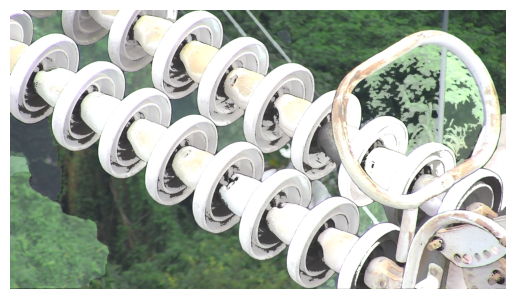

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the function to perform K-Means on a region within a polygon
def kmeans_on_region(image, polygon, num_clusters):
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [polygon], (255, 255, 255))
    masked_image = cv2.bitwise_and(image, mask)

    pixels = np.float32(masked_image.reshape(-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image

# Load the image
image_path = 'test_images/DJI_0556.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Perform K-Means on each polygon and accumulate the results
num_clusters = 2  # Number of clusters for K-Means

result_image = np.copy(image)
for polygon in Polygon:
    segmented_polygon = kmeans_on_region(image, np.array(polygon), num_clusters)
    result_image = cv2.addWeighted(result_image, 1, segmented_polygon.astype('uint8'), 0.7, 0)

# Display the final result
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

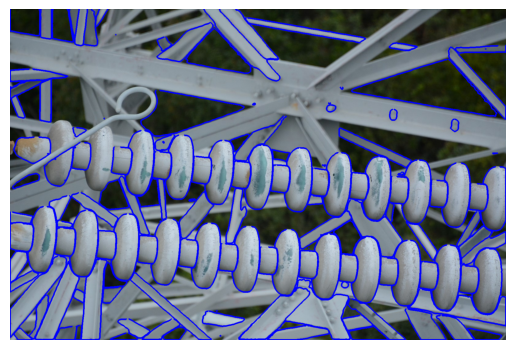

In [37]:
# Load the image
image_path = 'test_images/DSC_5641.JPG'  # Replace with your image path
image_rgb = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)
Polygon = GetPolygon(result)
for ind in range(len(Polygon)):
    img = cv2.polylines(image_rgb, [Polygon[ind]], False, (0,0,255), thickness=3)
    plt.imshow(img)
    plt.axis('off')
plt.show()

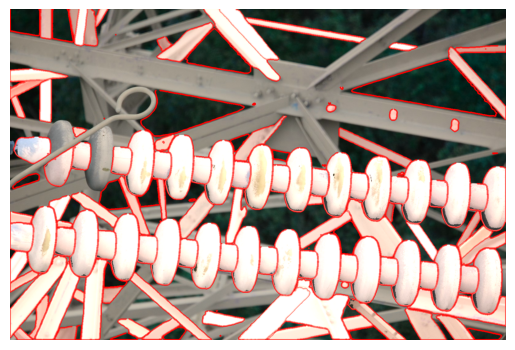

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the function to perform K-Means on a region within a polygon
def kmeans_on_region(image, polygon, num_clusters):
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [polygon], (255, 255, 255))
    masked_image = cv2.bitwise_and(image, mask)

    pixels = np.float32(masked_image.reshape(-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image

# # Load the image
# image_path = 'test_images/DSC_5641.JPG'  # Replace with your image path
# image_rgb = cv2.imread(image_path)

# image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
# result = mask_generator.generate(image_rgb)

# Polygon = GetPolygon(result)
# Perform K-Means on each polygon and accumulate the results
num_clusters = 2  # Number of clusters for K-Means

result_image = np.copy(image_rgb)
for polygon in Polygon:
    segmented_polygon = kmeans_on_region(image_rgb, np.array(polygon), num_clusters)
    result_image = cv2.addWeighted(result_image, 1, segmented_polygon.astype('uint8'), 0.7, 0)

# Display the final result
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [47]:
def OpenCVSegmentation(image_path,num_clusters = 2):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    result = mask_generator.generate(image_rgb)
    
    # get polygon
    Polygon = GetPolygon(result)
    
    result_image = np.copy(image_rgb)
    for polygon in Polygon:
        segmented_polygon = kmeans_on_region(image_rgb, np.array(polygon), num_clusters)
        result_image = cv2.addWeighted(result_image, 1, segmented_polygon.astype('uint8'), 0.7, 0)
        
    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1)
    plt.imshow(image_rgb)
    plt.title("Actual")
    plt.axis('off')
    
    
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("K-Means")
    plt.axis('off')

105.4874267578125
165.46663689613342
92.19025158882141


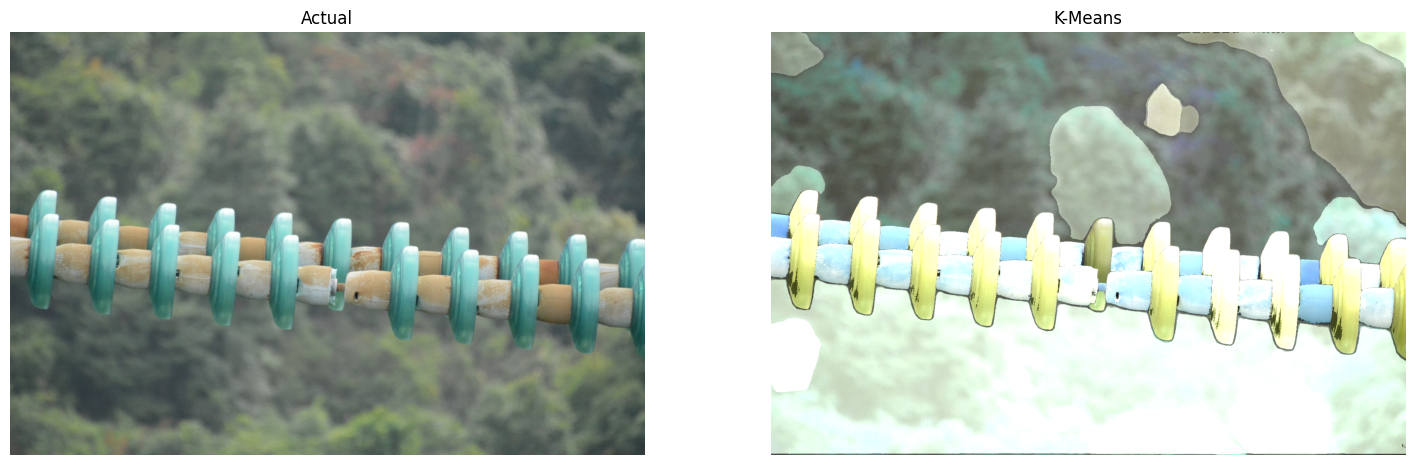

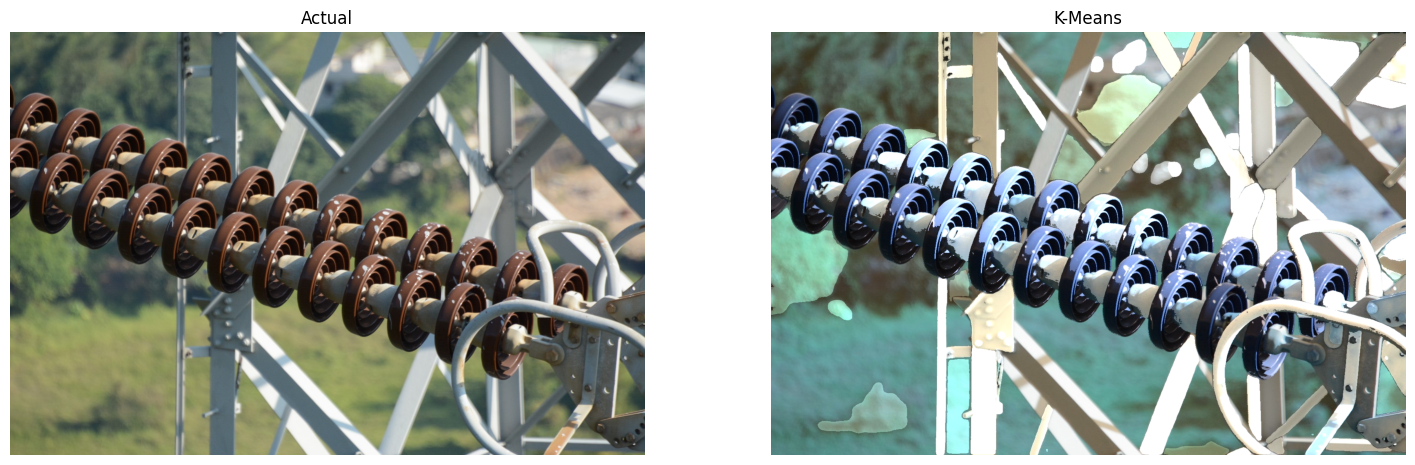

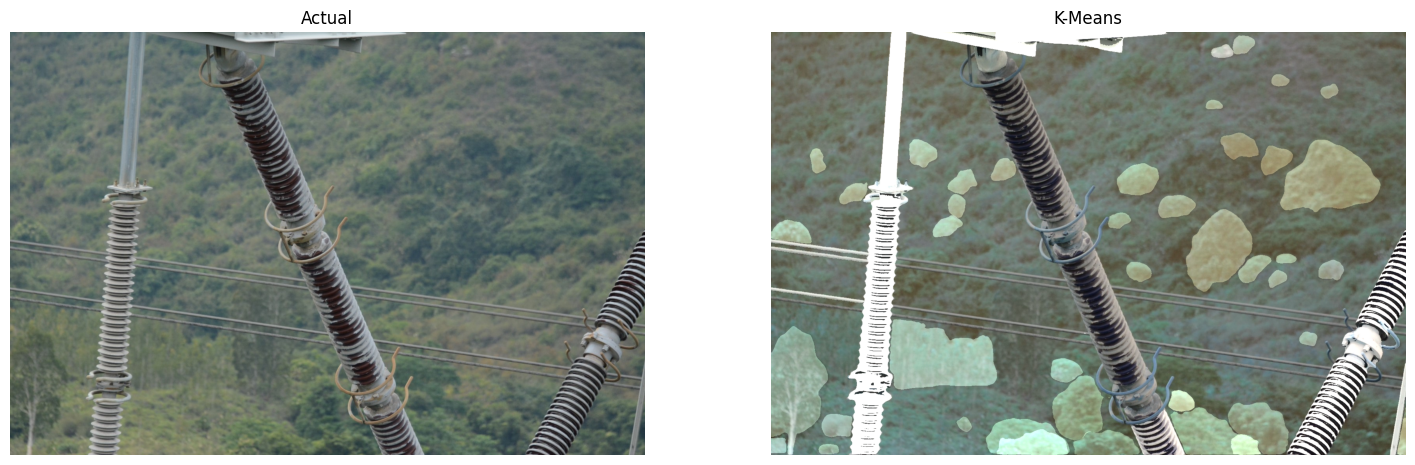

In [48]:
num_clusters = 2

images_path = glob('test_images/*')

for ind in np.random.randint(0, len(images_path),3):
    st = time.time()
    OpenCVSegmentation(images_path[ind],num_clusters = num_clusters)
    print(time.time()-st)

In [30]:
def GetPolygon(result):
    contours = []
    
    for ind in range(len(result)):
        # Assuming the result is a list of dictionaries and 'segmentation' key contains the segmentation mask
        segmentation_mask = result[ind]['segmentation']

        # Convert the segmentation mask to a binary mask
        segmentation_mask = np.uint8(segmentation_mask) * 255

        # # Find contours in the binary mask
        contour, _ = cv2.findContours(segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        contours.append(contour[0])
        
    return contours


# Define the function to perform K-Means on a region within a polygon
def kmeans_on_region(image, polygon, num_clusters):
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [polygon], (255, 255, 255))
    masked_image = cv2.bitwise_and(image, mask)

    pixels = np.float32(masked_image.reshape(-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image


def OpenCVSegmentation(image_path,num_clusters = 2):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    result = mask_generator.generate(image_rgb)
    
#     mask_annotator = sv.MaskAnnotator()
#     detections = sv.Detections.from_sam(result)
#     annotated_image = mask_annotator.annotate(image_bgr, detections)
    
    # get polygon
    Polygon = GetPolygon(result)
    
    result_image = np.copy(image_rgb)
    for polygon in Polygon:
        segmented_polygon = kmeans_on_region(image_rgb, np.array(polygon), num_clusters)
        result_image = cv2.addWeighted(result_image, 1, segmented_polygon.astype('uint8'), 0.7, 0)
        
    
    plt.subplot(1,2,1)
    plt.imshow(image_rgb)
    plt.title("Actual")
    plt.axis('off')
    
    
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("K-Means")
    plt.axis('off')

In [31]:
from glob import glob
import time
images_path = glob('test_images/*')

In [32]:
num_clusters = 2
images_path = glob('test_images/*')
for ind in np.random.randint(0, len(images_path),3):
    st = time.time()
    OpenCVSegmentation(images_path[ind],num_clusters = num_clusters)
    print(time.time()-st)

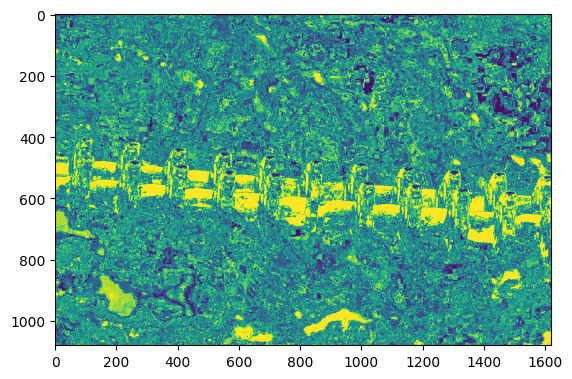

In [60]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

img = cv2.imread(images_path[3])

Z = np.float32(img.reshape((-1,3)))
db = DBSCAN(eps=0.8, min_samples=100).fit(Z[:,:2])

plt.imshow(np.uint8(db.labels_.reshape(img.shape[:2])))
plt.show()

Segmentation by Meanshift

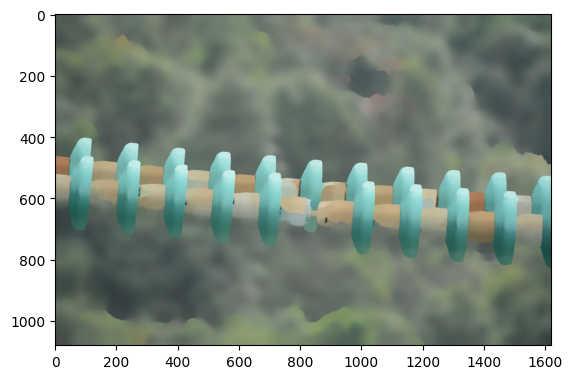

In [63]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
# from sklearn.datasets.samples_generator import make_blobs

img = cv2.imread(images_path[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
Z = np.float32(img.reshape((-1,3)))

img = cv2.pyrMeanShiftFiltering(img, 20, 50, 2000)
img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

plt.imshow(img)
plt.show()

Segmentation by Graphcut

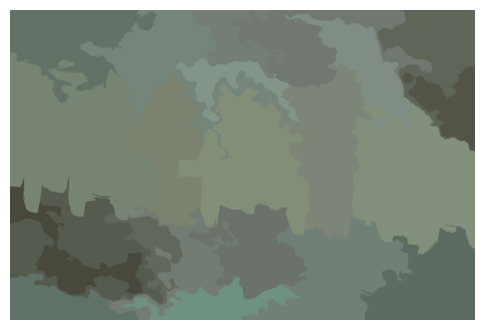

In [56]:
from skimage import data, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt

img = cv2.imread(images_path[3])

labels1 = segmentation.slic(img, compactness=5, n_segments=40)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

ax.imshow(out1)
ax.axis('off')
plt.show()

Segmentation by Watershed

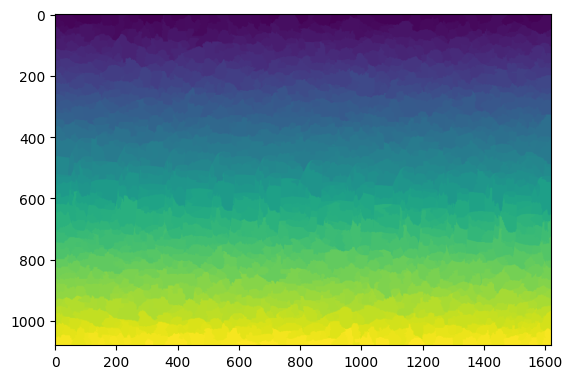

In [58]:
from skimage.segmentation import quickshift as qs
from skimage import data, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt

img = cv2.imread(images_path[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = qs(img, convert2lab=True)

plt.imshow(img)
plt.show()